<a href="https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/C3W1_Generative_Teaching_Networks_(Optional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Teaching Networks (GTN)

*Please note that this is an optional notebook, meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow! The first author of this work, Felipe Such, reviewed this notebook for you.*

### Goals 

In this notebook, you'll be implementing a Generative Teaching Network (GTN), first introduced in [Generative Teaching Networks: Accelerating Neural Architecture Search by Learning to Generate Synthetic Training Data](https://arxiv.org/abs/1912.07768) (Such et al. 2019). Essentially, a GTN is composed of a generator (i.e. teacher), which produces synthetic data, and a student, which is trained on this data for some task. The key difference between GTNs and GANs is that GTN models work cooperatively (as opposed to adversarially).

Throughout this notebook, you'll gain (deeper) exposure to the following concepts:

1. **End-to-End Data Augmentation.** Data augmentation refers to the generation of more data from existing data to *augment* the training set. Examples of this with images include operations like random cropping and flipping. In this sense, the generator performs data augmentation by synthesizing data as extra training data. GTNs differ from previous data augmentation approaches in that:
    - The generator and student are trained together, as opposed to training and freezing the generator, then training the student.
    - The real data plays a small role: it's only used once every several student updates to update the generator with respect to the student's performance.
    - The generated data doesn't look realistic (see visualization later in notebook) yet it's more effective for training the student than real data is!

2. **Curriculum Learning.** The generator not only can synthesize data from random noise, but also can learn this random noise, or *curriculum*. By backpropagating through the inputs, the generator can be trained to select the curricula that it deems will be best for student learning.

3. **Meta-Learning.** Meta-learning refers to "learning to learn," a broad field that optimizes over different learning tasks to find the best way to learn. You're probably an example of a good meta-learner :). A GTN accomplishes this by training the generator to understand how the student learns, demonstrated via curriculum learning.

4. **Neural Architecture Search.** But wait, there's still more! The generator doesn't just guide student training, it also can help determine the optimal student architecture (i.e. which layers, network depth). This concept of learning the best architecture is called Neural Architecture Search, or NAS. Pretty convenient, huh!

![Figure 1a from the paper](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/gtn_fig1.png?raw=true)
*Figure 1(a) from the [GTN paper](https://arxiv.org/pdf/1912.07768.pdf), providing an overview of the method*

### Learning Objectives

By the end of this notebook, you should:

1. Understand the concepts of teaching networks, meta-learning, and neural architecture search, and how they relate to the objective of data augmentation.
2. Implement and train a GTN on MNIST, and observe how a GTN can accelerate training.

## Getting Started

Start by running the following two cells. The first cell imports packages that you'll use and checks whether the package, [Higher](https://github.com/facebookresearch/higher) (by Facebook Research), is installed. Higher allows you to "unroll" inner gradient updates. Unrolling inner updates means that instead of computing updates in a loop where previous updates are overwritten (i.e. one step of traditional SGD), each update is stored, which makes it easier to compute and apply gradients to the generator through multiple updates of the student.


In [ ]:
import os
import sys
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.autograd import grad

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

if 'higher' not in sys.modules:
  !pip install higher
import higher as higher

print(sys.version)
print(torch.__version__)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.6.0+cu101


In [ ]:
# Set random seeds
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Set important parameters
learning_rate = 1e-2
inner_loop_iterations = 32
outer_loop_iterations = 5
num_classes = 10

noise_size = 64     # size of noise or curriculum vector
img_size = 28    # width / height of generated image

inner_loop_batch_size = 128
outer_loop_batch_size = 128

mnist_mean = 0.1307         # for normalizing mnist images
mnist_std = 0.3081          # for normalizing mnist images

imgs_per_row = num_classes

### Dataset

Download the MNIST dataset and organize it into a `torch.utils.data.Dataset` object. Then apply `torchvision.transforms` to convert raw PIL images to tensors.

In [ ]:
# Initialize MNIST transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x)),
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,)),
])

# Create data splits
train = datasets.MNIST('./data', train=True, transform=transform, download=True)
train, val = torch.utils.data.random_split(train, [50000, 10000])
test = datasets.MNIST('./data', train=False, transform=transform, download=True)
print('Created train, val, and test datasets.')

Created train, val, and test datasets.


### Dataloader

Now wrap your dataset class in a `torch.utils.data.DataLoader` class, which will iterate over batches in training. This class increases memory access bandwidth so retrieving images from your dataset won't be a bottleneck in training. MNIST images are small, so the increase in memory retrieval speed should be relatively trivial.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=outer_loop_batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True,
)

## MNIST Classification

In this next section, you'll implement and train a GTN on MNIST classification. Note that the student model for this task is a classifier. To extend GTNs to other datasets, you also want to check out the weight normalization technique in the paper --- for now on MNIST, you don't need to worry about this. Alright, let's get started with the generator and classifier's model architecture!

### Generator 

Let's now build the generator. For this task, the generator will consist of two fully connected blocks (each consisting of a fully connected layer, a leaky ReLU, and a batch normalization layer) and two convolutional blocks (each consisting of a convolutional layer, a batch normalization layer and a leaky ReLU). A tanh layer is applied to this output to center it around `0` with reasonable standard deviation.

In [ ]:
class Teacher(nn.Module):
    '''
    Implements a Teacher module.
    '''
    def __init__(self):
        super().__init__()

        conv1_filters = 64
        fc1_size = 1024
        
        self.fc2_filters = 128
        self.fc2_width = img_size
        fc2_size = self.fc2_filters * self.fc2_width * self.fc2_width

        self.fc1 = nn.Linear(noise_size + num_classes, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, 0.1)
        self.bn_fc1 = nn.BatchNorm1d(fc1_size, momentum=0.1)

        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, 0.1)
        self.bn_fc2 = nn.BatchNorm2d(self.fc2_filters, momentum=0.1)

        self.conv1 = nn.Conv2d(self.fc2_filters, conv1_filters, 3, 1, padding=3 // 2)
        self.bn_conv1 = nn.BatchNorm2d(conv1_filters, momentum=0.1)

        self.conv2 = nn.Conv2d(conv1_filters, 1, 3, 1, padding=3 // 2)
        self.bn_conv2 = nn.BatchNorm2d(1, momentum=0.1)
        
        self.tanh = nn.Tanh()

        self.learner_optim_params = nn.Parameter(torch.tensor([0.02, 0.5]), True)

    def forward(self, x, target):
        '''
        Synthesizes a batch of training examples for the learner.
        Args:
            x (torch.tensor): shape (b, 64)
            target (torch.tensor): shape (b, 10)
        '''
        # Fully connected block 1
        x = torch.cat([x, target], dim=1)   # shape (b, 64+10)
        x = self.fc1(x)                     # shape (b, 1024)
        x = F.leaky_relu(x, 0.1)
        x = self.bn_fc1(x)

        # Fully connected block 2
        x = self.fc2(x)                     # shape (b, 128*28*28)
        x = F.leaky_relu(x, 0.1)
        x = x.view(                         # shape (b, 128, 28, 28)
            -1, self.fc2_filters, self.fc2_width, self.fc2_width
        )
        x = self.bn_fc2(x)

        # Convolutional block 1
        x = self.conv1(x)                   # shape (b, 64, 28, 28)
        x = self.bn_conv1(x)
        x = F.leaky_relu(x, 0.1)

        # Convolutional block 2
        x = self.conv2(x)                   # shape (b, 1, 28,  28)
        x = self.bn_conv2(x)

        x = (self.tanh(x) + 1 - 2 * mnist_mean) / (2 * mnist_std)
        return x, target 

### Classifier 

Now let's build the student model, a classifier. Be sure to randomize the number of convolutional filters in the first and second convolution layers so the teacher generalizes to other architectures. This is important since it'll help the teacher perform neural architecture search later.

For MNIST classification, the classifier consists of two convolutional blocks (each consisting of a convolutional layer, a leaky ReLU, a batch normalization layer and a max pooling). After these layers, the output is flattened and passed through a fully connected layer, a batch normalization layer, and a softmax to generate probabilities per class.

In [ ]:
class Learner(nn.Module):
    '''
    Implements a Learner module.
    '''
    def __init__(self, num_conv1=None, num_conv2=None):
        super().__init__()

        # Randomly select and evaluate convolutional depth
        # for evaluation/comparison in neural architecture search
        if num_conv1 is None:
            conv1_filters = np.random.randint(32, 64)
        else:
            conv1_filters = num_conv1
        if num_conv2 is None:
            conv2_filters = np.random.randint(64, 128)
        else:
            conv2_filters = num_conv2

        self.conv1 = nn.Conv2d(1, conv1_filters, 3, 1)
        self.bn1 = nn.BatchNorm2d(conv1_filters, momentum=0.1)

        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 3, 1)
        self.bn2 = nn.BatchNorm2d(conv2_filters, momentum=0.1)

        c1_size = (img_size - 3 + 1) // 2
        c2_size = (c1_size - 3 + 1) // 2
        
        self.fc = nn.Linear(conv2_filters * c2_size * c2_size, num_classes)
        self.bn3 = nn.BatchNorm1d(num_classes, momentum=0.1)
        
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.bn3(x)

        return x

### Training 

*Note: can run on CPU but need high RAM version of Colab.*

Now let's extend the inner loop implementation to train the outer loop loss function. After training the classifier on the synthetic data every `inner_loop_iterations`, evaluate the classifier on a batch of real data and backpropagate the resulting loss to the generator.

After training for about 50 outer loop iterations, your validation accuracy should approach 90%. This means that your teacher is so good that it gets your student to a 90% validation accuracy with 32 iterations. That's pretty cool! Notice how the images don't look much like numbers. These images represent a compressed version of the training images with the most salient information needed for training.

In [ ]:
def generate_img(img_tensor):
    '''
    Function that renders an MNIST image.
    '''
    return torchvision.transforms.ToPILImage()(1 - ((img_tensor * mnist_std) + mnist_mean))

In [ ]:
teacher = Teacher()
params_to_train = list(teacher.parameters())

# If we want to use a curriculum, we initialize the learnable parameters here
use_curriculum = True
if use_curriculum:
    curriculum = nn.Parameter(torch.randn(inner_loop_iterations, inner_loop_batch_size, noise_size), requires_grad=True)
    params_to_train += [curriculum]

optimizer_teacher = optim.Adam(params_to_train, lr=learning_rate)

# For each inner loop iterations, we use the same sequence of labels. 
# This allows the curriculum vectors to train to stable labels 
label = torch.tensor([x % num_classes for x in range(inner_loop_batch_size)])

# For the inner loop loss, we use cross entropy
loss_fn = nn.CrossEntropyLoss()

# Here we initialize iterators on the train and val datasets
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)
test_iterator = iter(test_loader)

In [ ]:
for it, real_data in enumerate(train_loader):

    teacher.train()
    optimizer_teacher.zero_grad()

    # We also optimize the learner learning rate and momentum with the
    # outer loop updates
    learner_lr = teacher.learner_optim_params[0]
    learner_momentum = teacher.learner_optim_params[1]

    # Here we sample a learner with random number of conv filters
    learner = Learner()
    inner_optim = optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
    learner.train()

    inner_losses = []
    with higher.innerloop_ctx(learner, inner_optim, override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner, diffopt):
        for step in range(inner_loop_iterations):

            # Data generation
            if use_curriculum:
                z_vec = curriculum[step]
            else:
                z_vec = torch.randn(inner_loop_batch_size, noise_size)

            one_hot = F.one_hot(label, num_classes)
    
            # Pass input to teacher to generate synthetic images
            teacher_output, teacher_target = teacher(z_vec, one_hot)

            # ====== Show intermediate generated images ======
            if step == 0:
                print('------------------ Outer loop iteration', it + 1, '------------------')
                print('Examples 0 - 9 from beginning of inner loop:')
                background = Image.new('L', (img_size * imgs_per_row + imgs_per_row + 1, img_size + 2))
                for i in range(imgs_per_row): # indexes column 
                    background.paste(generate_img(teacher_output[i]), (i * 28 + i + 1, 1))
                display(background)

            if step == (inner_loop_iterations - 1):
                print('Examples 0 - 9 from end of inner loop:')
                background = Image.new('L', (img_size * imgs_per_row + imgs_per_row + 1, img_size + 2))
                for i in range(imgs_per_row): # indexes column
                    background.paste(generate_img(teacher_output[i]), (i * 28 + i + 1, 1))
                display(background)

            # Pass teacher output to the learner 
            learner_output = flearner(teacher_output)
            loss = loss_fn(learner_output, label)
            diffopt.step(loss)

            inner_losses.append(loss.item())

        correct = 0
        data, target = real_data
        output = flearner(data)
        loss = loss_fn(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy_train = correct / target.shape[0]

        print("Inner loop losses:", inner_losses)
        print("Train accuracy:", accuracy_train)

        # Compute accuracy on validation set
        data, target = next(val_iterator)
        print
        output = flearner(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / outer_loop_batch_size
        print("Val accuracy:", accuracy)

        if (it == outer_loop_iterations - 1):
            # Compute accuracy on test set
            correct = 0
            for i, (data, target) in enumerate(test_loader):
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test_loader))
            print("----------------------------------")
            print("Done training...")
            print("Final test accuracy:", accuracy)

            # Final inner loop training curve
            plt.plot(np.arange(len(inner_losses)), inner_losses)
            plt.xlabel("Inner loop iteration")
            plt.ylabel("Cross entropy loss")
            plt.show()

            break

        loss.backward()

    optimizer_teacher.step()

------------------ Outer loop iteration 1 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.7236783504486084, 2.6256988048553467, 2.672574758529663, 2.6134140491485596, 2.596022844314575, 2.6138412952423096, 2.5911357402801514, 2.2683398723602295, 2.4912025928497314, 2.3700554370880127, 2.4646973609924316, 2.5557470321655273, 2.377898693084717, 2.389883518218994, 2.282891273498535, 2.1598823070526123, 2.371140241622925, 2.246856451034546, 2.4149580001831055, 2.284665107727051, 2.3528828620910645, 2.2198994159698486, 2.27508282661438, 2.162252426147461, 2.2586324214935303, 2.2811717987060547, 2.254401445388794, 2.224247455596924, 2.2326204776763916, 2.1681580543518066, 2.0837442874908447, 2.0746254920959473]
Train accuracy: 0.0703125
Val accuracy: 0.109375
------------------ Outer loop iteration 2 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.648425340652466, 2.265460252761841, 1.8753728866577148, 1.6502933502197266, 1.4719526767730713, 1.5776382684707642, 1.487295150756836, 1.3296877145767212, 1.3358333110809326, 1.2487596273422241, 1.285240888595581, 1.235264778137207, 1.3077187538146973, 1.296455979347229, 1.1424646377563477, 1.1681510210037231, 1.1846617460250854, 1.1983927488327026, 1.130386233329773, 1.113377332687378, 1.1521409749984741, 1.155056357383728, 1.1762973070144653, 1.0792546272277832, 1.0710194110870361, 1.050790548324585, 1.0769656896591187, 0.9832346439361572, 1.0515564680099487, 1.0672335624694824, 1.0967187881469727, 1.133283257484436]
Train accuracy: 0.6484375
Val accuracy: 0.640625
------------------ Outer loop iteration 3 ------------------
Examples 0 - 9 from beginning of inner loop:


Examples 0 - 9 from end of inner loop:


Inner loop losses: [2.6590287685394287, 1.7501730918884277, 1.6416189670562744, 1.4128144979476929, 1.2072248458862305, 1.2262474298477173, 1.166333556175232, 1.0464897155761719, 1.1477928161621094, 1.0602245330810547, 1.0258921384811401, 0.9966067671775818, 0.9745022654533386, 0.9789420366287231, 0.9151432514190674, 0.9637138843536377, 0.8352720737457275, 0.8378331065177917, 0.8227945566177368, 0.850355863571167, 0.8167492151260376, 0.8021303415298462, 0.7668197751045227, 0.7336200475692749, 0.7555335164070129, 0.741989016532898, 0.7746337056159973, 0.7558042407035828, 0.6931012272834778, 0.6824826002120972, 0.7050946950912476, 0.7332448363304138]
Train accuracy: 0.703125
Val accuracy: 0.765625


## Simple MNIST NAS

The key idea of this paper is that performance of larger networks on teacher-generated data is a good proxy for performance on real data, allowing you to search over many more architectures with limited compute. In fact, Such et al. state,

> We found that to achieve the same predictive power (rank correlation) as achieved with only 128 SGD steps on GTN-generated data, you would instead need 1200 SGD steps on real data.

With enough compute, you could train the teacher on large networks sampled from a NAS space, gradually increasing the number of inner loop updates and architectures per outer loop update. This would provide an end-to-end NAS model. However, Such et al. found that this is prohibitively expensive. Thus, the teacher is only trained on small networks with the hope that it'll generalize well to larger, more powerful networks.

Now let's implement a simple neural architecture search (NAS) with your GTN. In this search, you'll optimize the number of convolutional filters for the two-layer student network you trained your teacher on earlier.

In [ ]:
num_architectures = 10

best_accuracy = 0

for i in range(num_architectures):

    # Randomly sample architecture
    conv1_filters = np.random.randint(1, 64)
    conv2_filters = np.random.randint(1, 128)

    learner = Learner(conv1_filters, conv2_filters)
    inner_optim = optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
    learner.train()

    # For some reason if we don't use higher here, accuracy drops significantly
    with higher.innerloop_ctx(learner, inner_optim, override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner, diffopt):
        for step in range(inner_loop_iterations):

            # Data generation
            if use_curriculum:
                z_vec = curriculum[step]
            else:
                z_vec = torch.randn(inner_loop_batch_size, noise_size)

            one_hot = F.one_hot(label, num_classes)

            # Pass input to teacher to generate synthetic images
            teacher_output, teacher_target = teacher(z_vec, one_hot)

            # Pass teacher output to the learner
            learner_output = flearner(teacher_output)
            loss = loss_fn(learner_output, label)
            diffopt.step(loss)

        # Compute accuracy on validation set
        correct = 0
        for val_idx, (data, target) in enumerate(val_loader, 0):
            #if (val_idx == val_iterations): break
            output = flearner(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / (outer_loop_batch_size * len(val_loader))

        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            filter_counts = (conv1_filters, conv2_filters)

        print("------------------------- Architecture", i + 1," -------------------------")
        print("Num conv1 filters:", conv1_filters, ", Num conv2 filters:", conv2_filters, ", Val accuracy:", accuracy)

        
        if (i == num_architectures - 1):
            correct = 0
            for test_idx, (data, target) in enumerate(test_loader, 0):
                #if (test_idx == test_iterations): break
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test_loader))
            print("------------------------- Best architecture -------------------------")
            print("Num conv1 filters:", filter_counts[0], ", Num conv2 filters:", filter_counts[1], ", Test accuracy:", accuracy)
          

------------------------- Architecture 1  -------------------------
Num conv1 filters: 22 , Num conv2 filters: 115 , Val accuracy: 0.8155048076923077
------------------------- Architecture 2  -------------------------
Num conv1 filters: 37 , Num conv2 filters: 88 , Val accuracy: 0.8197115384615384
------------------------- Architecture 3  -------------------------
Num conv1 filters: 7 , Num conv2 filters: 89 , Val accuracy: 0.8247195512820513
------------------------- Architecture 4  -------------------------
Num conv1 filters: 25 , Num conv2 filters: 13 , Val accuracy: 0.7846554487179487
------------------------- Architecture 5  -------------------------
Num conv1 filters: 59 , Num conv2 filters: 66 , Val accuracy: 0.8151041666666666
------------------------- Architecture 6  -------------------------
Num conv1 filters: 39 , Num conv2 filters: 40 , Val accuracy: 0.8113982371794872
------------------------- Architecture 7  -------------------------
Num conv1 filters: 24 , Num conv2 filt

### Visualization 

The rows in the grid produced are images from equally-spaced inner loop iterations where the first row corresponds to the first inner loop iteration and the last row corresponds to the last. The columns correspond to classes where the first column is filled with 0's and the last colummn is filled with 9's.

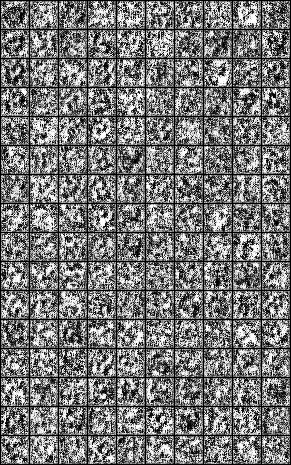

In [ ]:
imgs_per_row = num_classes
rows = inner_loop_iterations // 2 * img_size + inner_loop_iterations // 2 + 1
cols = imgs_per_row * img_size + imgs_per_row + 1
background = Image.new('L', (cols, rows))

for step in range(0, inner_loop_iterations, 2): # indexes row
    if use_curriculum:
        z_vec = curriculum[step]
    else:
        z_vec = torch.randn(inner_loop_batch_size, noise_size)

    one_hot = F.one_hot(label, num_classes)

    teacher_output, teacher_target = teacher(z_vec, one_hot)

    for i in range(imgs_per_row): # indexes column 
        background.paste(generate_img(teacher_output[i]), (i * img_size + i + 1, (step // 2) * img_size + (step // 2) + 1))

display(background)

### Conclusion

Now you know how GTN-generated data augmentation can be useful for training classifiers quickly which in turn allows us to more efficiently search for best performing model architectures. You've seen how the whole process can be trained end-to-end, instead of training one model first, then another — you can certainly apply this principle elsewhere as you build your systems, merging different steps of the training process as you let the gradient flow all the way through your system! You've touched on evolving areas of research, such as curriculum learning, meta-learning, and neural architecture search (NAS), which you can also take to your other projects.